# Assignment 6: Generative Models


## Given

Import Tensorflow and other libraries we need

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

!pip install imageio
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import time

from IPython import display

## Exercise 1: Variational Auto Encoder (21 points)

### 1.1 Data Preparation (2 points)
- Get the MNIST dataset from Keras
- Reshape the data to `28x28x1` images
- Normalize data to $[0,1]$ range
- Binarize the data with a $0.5$ threshold
- Split into training and validation dataset

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_size = 60000
test_size = 10000
optimizer = tf.keras.optimizers.Adam(1e-4)


11493376/11490434 [==============================] - 0s 0us/step


### 1.2 Define the VAE model (8 points)
Define a convolutional variational auto encoder as `tf.keras.Model`. The encoder should consist of two stride 2 convolutions (32, 64 filters should work), each with kernel size 3 and ReLU activation, following by a fully connected layer to produce a latent space of size `latent_dim` (note that is mean and std for each). The decoder should be symmetric to the encoder, using transpose convs with stride 2 for upsampling.
Your VAE model class should have four methods, as indicated by the function signatures below. See their docstrings for a short description

Tips:
- We will have the encoder produce a log variance rather than a standard deviation. This is only for numerical stability. To get from log variance to standard deviation do $e^{0.5 \cdot logvar}$.
- Make your fully connected layer in the encoder output `2*latent_dim` and use `tf.split` to extract mean and std from its output.

In [ ]:
class CVAE(tf.keras.Model):

    def __init__(self, latent_dim):
      super(CVAE, self).__init__()
      self.latent_dim = latent_dim
      self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

      self.decoder = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
              tf.keras.layers.Conv2DTranspose(
                  filters=64, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=32, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=1, kernel_size=3, strides=1, padding='same'),
          ]
      )

    @tf.function
    def sample(self, eps=None):
        ''' Sample an image from a latent vector `eps` and feed it through the decoder 
        Args: 
            eps is the latent code to be fed through the decoder. If eps is None, sample it randomly from N(0, I).
        Returns:
            Decoded latent vector / generated image
        '''
        if eps is None:
          eps = tf.random.normal(shape=(100, latent_dim))
        return self.decode(eps, apply_sigmoid=True)


    def encode(self, x, training=True):
        ''' Encode a batch of images. Outputs (`mean`, `log variance`) 
            Args:
                x: the batch of input images to encode
                training: Whether operations like BatchNorm and Dropout should apply for encoding. Defaults to True.
            Returns: The mean and log variance of the posterior distribution    
        '''
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        ''' Sample a random N(0, I) and reparameterize with `mean` and `logvar` '''
        epsilon = tf.random.normal(shape=mean.shape)
        return mean + tf.exp(0.5 * logvar) * epsilon

    def decode(self, z, apply_sigmoid=False, training=True):
        ''' Decode the latent vector `z`. With `apply_sigmoid=True` the resulting image is scaled to (0, 1), otherwise logits are returned
            Args:
                z: the batch of latent vectors to decode
                apply_sigmoid: Whether the output is scaled to (0,1). Defaults to False.
                training: Whether operations like BatchNorm and Dropout should apply for decoding. Defaults to True.
            Returns: The decoded image
        '''
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

### 1.3 Define training and validation steps (6 points)
A validation step consists of first encoding a batch of inputs, sampling the latent vector using the reparameterization trick, decoding the sampled latent vector and computing the loss for this prediction. The training step does the same while tracking the gradients and lastly also having the optimizer apply the gradients to the model.

The loss is a combination of negative log likelihood $-\log{p(x|z)}$ (use cross entropy) and Kullback-Leibler divergence of the posterior samples and the desired latent space prior, which is $\mathcal{N}(0, I)$. The `log_normal_pdf(z, mean, logvar)` function gives you the probability density of sample `z` in a normal distribution with the given `mean` and `logvar` (log variance). 

**Note:** 
In the lecture the encoder is described to output a standard deviation, while the use of log variance is used throughout this implementation. This is due to numerical stability reasons. For the computation of the KL divergence in the VAE loss, you can use $\log{p(z)} - \log{q(z|x)}$, where $\log{p(z)}$ and $\log{q(z|x)}$ can be computed by `log_normal_pdf(z, 0.0, 0.0)` and `log_normal_pdf(z, mean, logvar)` respectively. 


In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    '''  Computes the probability of `sample` for a Gaussian normal distribution with `mean` and log variance `logvar`. '''
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)
  
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def valid_step(model, x):
    ''' Performs a validation step for `model` with the input batch `x` 
    Args:
        model: The `tf.keras.Model` to be validated
        x:     The batch of input data (must be compatible with `model`)
    Returns:
        A tuple of (loss, sigmoid-scaled prediction)
    '''
    loss = compute_loss(model, x)

    return loss

@tf.function
def train_step(model, x, optimizer):
    ''' Performs a training step by feeding `x` through the model, computing the loss, gradients and updating the weights. Returns the sigmoid-scaled predictions
    Args:
        model: The `tf.keras.Model` to be trained
        x:     The batch of input data (must be compatible with `model`)
        optimizer: The `tf.keras.optimizer` that shall be used for weight updates
    Returns:
        A tuple of (loss, sigmoid-scaled prediction)
    '''
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

### 1.4 Train the VAE (4 points)
Train your model for several epochs using the Adam optimizer. Reasonable hyperparameter choices to start with are:
- learning rate `1e-4`
- latent space dimension `32`
- epochs `50`
- batch size `128`

Make sure to plot your training progress in the form of plotting training and validation loss (every epoch), as well as inspecting the actual reconstructions on both the train and validation dataset. You can use the `plot_orig_recon` and `plot_loss_curves` functions. Make sure to set the `clear_output` parameter to `True` for the first plot call in your code.

In [ ]:
def plot_orig_recon(orig, recon, clear_output=False):
    ''' Plot the original images (top) and reconstructed images (bottom) '''
    fig = plt.figure(figsize=(30,6))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(orig[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i+11)
        plt.imshow(recon[i, :, :, 0], cmap='gray')
        plt.axis('off')
    if clear_output: display.clear_output(wait=False)
    plt.show()
    
def plot_loss_curves(t_loss, v_loss, clear_output=False):
    ''' Plots the training and validation losses. '''
    fig = plt.figure(figsize=(6,3))
    plt.plot(t_loss, label='Train Loss')
    plt.plot(v_loss, label='Valid Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('-ELBO')
    if clear_output: display.clear_output(wait=False)
    plt.show()

Epoch: 1, time elapse for current epoch: 3.9098334312438965
Epoch: 2, time elapse for current epoch: 2.754230499267578
Epoch: 3, time elapse for current epoch: 2.78669810295105
Epoch: 4, time elapse for current epoch: 2.7913317680358887
Epoch: 5, time elapse for current epoch: 2.796142339706421
Epoch: 6, time elapse for current epoch: 2.8106470108032227
Epoch: 7, time elapse for current epoch: 2.829833984375
Epoch: 8, time elapse for current epoch: 2.8392081260681152
Epoch: 9, time elapse for current epoch: 2.8352468013763428
Epoch: 10, time elapse for current epoch: 2.8244612216949463


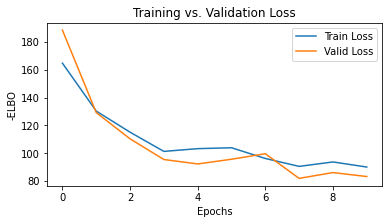

In [ ]:
epochs = 10
latent_dim = 32
batch_size=128

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

#random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
#model.trainable_variables
t_loss=[]
v_loss = []
for epoch in range(1, epochs + 1):
  loss=0
  start_time = time.time()
  for train_x in train_dataset:
    loss=train_step(model, train_x, optimizer)
  end_time = time.time()
  t_loss.append(loss)
  
  loss1=0
  for test_x in test_dataset:
    loss1=valid_step(model, test_x)
  v_loss.append(loss1)
  #plot_orig_recon(orig, recon, True)

  print('Epoch: {}, time elapse for current epoch: {}'.format(epoch, end_time - start_time))
plot_loss_curves(t_loss,v_loss,False)


### 1.5 Generate some new digits (1 point)
Plot a few newly generated images using your best parameters and random latent vectors.

Comparison of Input and output of the model


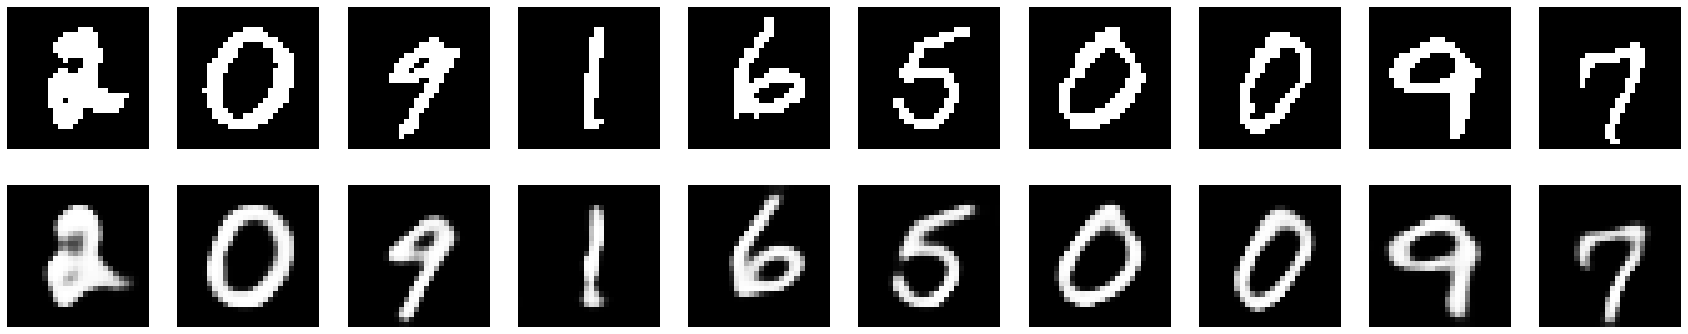

Comparison Using random vector


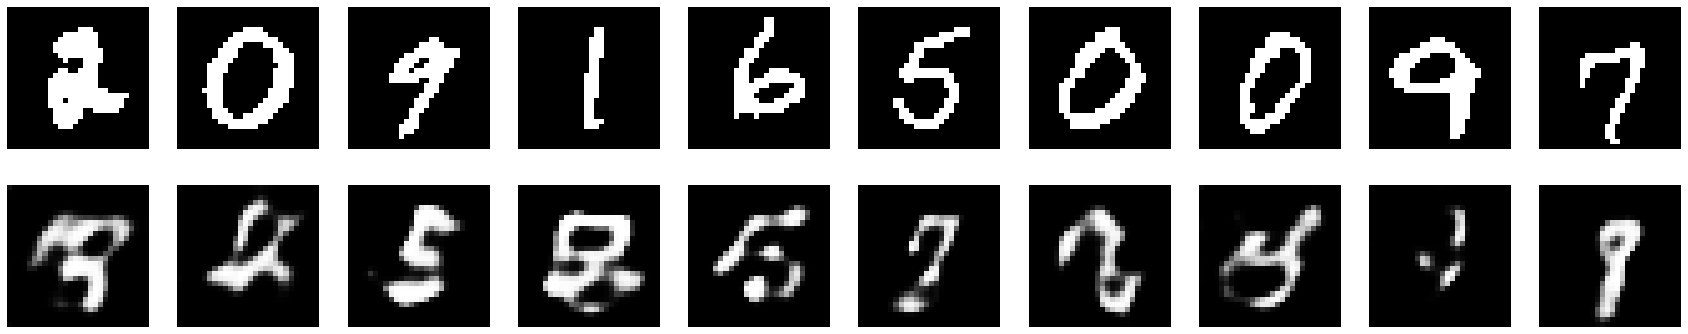

In [ ]:
# set the dimensionality of the latent space to a plane for visualization later


# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

mean, logvar = model.encode(test_sample)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)

print("Comparison of Input and output of the model")
plot_orig_recon(test_sample,predictions,False)
print("Comparison Using random vector")
ran=tf.random.normal(shape=(100, 32))
plot_orig_recon(test_sample,model.sample(ran),False)

## Exercise 2: Generative Adversarial Networks (24 points)

### 1.1 Prepare the dataset (2 points)
For the DCGAN, use the FashionMNIST dataset instead of normal MNIST. For the GAN you will only need to reshape the FashionMNIST data to `28x28x1` and normalize the images from $[0,255]$ to $[-1,1]$. Note that you won't need a validation set.

**Hyperparameters:** Use a batch size of 256 on Colab.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

4423680/4422102 [==============================] - 0s 0us/step


### 1.2 Define the GAN model (8 points)
**Generator:**
Start with a fully connected layer from `latent_dim` inputs to `7*7*256` outputs. Reshape to a `7x7x256` image, then follow with three transpose convs (kernel size 5, padding same, no bias) with `128, 64, 1` output feature maps. Use BatchNorm and LeakyReLU between all parameterized layers. Lastly set the last convolutions activation function to $\tanh{}$ to scale the output in the $[-1,1]$ range.

**Discriminator:**
Use two (Conv, LeakyReLU, Dropout) blocks, then add a fully connected layer to output a single number.

**Hyperparameters:** Set `noise_dim=100`

tf.Tensor([[-0.00055952]], shape=(1, 1), dtype=float32)


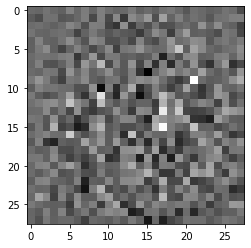

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

noise_dim=100
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

### 1.3 Define the losses and optimizers (4 points)
Optimizing the discriminator loss sould make the model produce a `1` for real images and a `0` for fake images.
Optimizing for the generator loss should make the model produce a `1` for fake images.
Use binary cross entropy (from logits), just as you would in binary classification. The "labels" can be generated with `tf.ones_like` and `tf.zeros_like`.

**Hyperparameters:** Use Adam for both the generator optimizer and discriminator optimizer. `1e-4` is a reasonable learning rate.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    ''' Computes the discriminator loss from the discriminator's output for real images (`real_output`) and fake images (`fake_output`) '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    ''' Computes the generator loss from the discriminator's output for fake images (`fake_output`) '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


### 1.4 Define the training step and training loop (10 points)
As before, fill in the `train_step` method below. One training step shall include a step for both the generator and the discriminator. 
Tip: You will have to use two gradient tapes or a persistent gradient tape to get gradients from both generator loss and discriminator loss.


Then define a training loop which plots a set of generated images every epoch to keep track of the GAN's progress (use `generate_and_show_images`).

Train your model for around 50 epochs or until you get reasonable generated images.

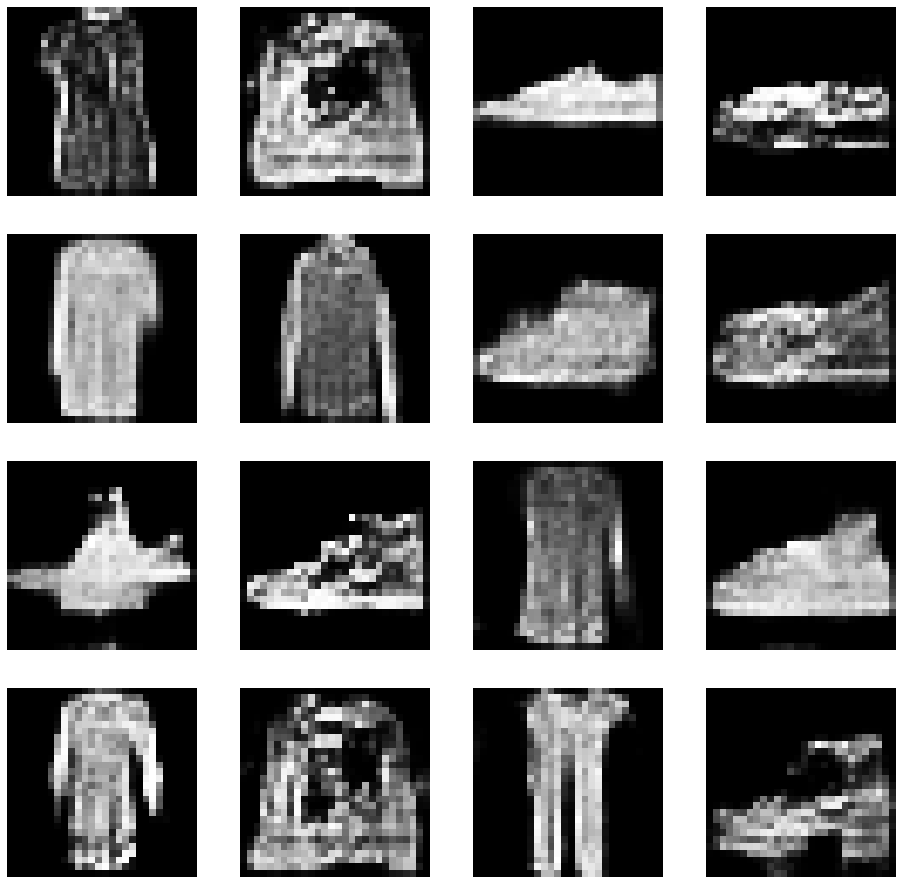

In [ ]:
def generate_and_show_images(model, test_input):
    ''' Generates and plots images using the generator `model` and its latent vector input `test_input`    
    Args:
        model (tf.keras.Model): The generator model
        test_input: The batch of latent vectors to be fed in the generator
    '''
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(16,16))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

@tf.function
def train_step(real_images):
    ''' Performs a full training step for both generator and discriminator.
    Args:
        real_images: Batch of real images from the dataset
     '''
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      
      real_output = discriminator(real_images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

#random input for the generator
seed = tf.random.normal([16, noise_dim])
for epoch in range(50):
  start = time.time()

  for image_batch in train_dataset:
    train_step(image_batch)

  # Produce images for the GIF as we go
  display.clear_output(wait=True)
  generate_and_show_images(generator,seed)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_show_images(generator,seed)